In [6]:
import pandas as pd  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


In [8]:
file_loc = "../Resources/ModelData/train_test_data.csv"
customer_complaints_df = pd.read_csv(file_loc)
customer_complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7684 entries, 0 to 7683
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       7684 non-null   object
 1   Consumer complaint narrative  7684 non-null   object
dtypes: object(2)
memory usage: 120.2+ KB


In [9]:
# Use a subset of columns for clustering (excluding labels)
clustering_features = customer_complaints_df[["Product", "Consumer complaint narrative"]]

# Encode categorical features and preprocess text
categorical_features = ["Product"]
text_feature = "Consumer complaint narrative"

# Preprocess categorical features using one-hot encoding
categorical_encoded = pd.get_dummies(clustering_features[categorical_features])

# Preprocess text feature using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
text_encoded = tfidf.fit_transform(clustering_features[text_feature])

# Combine encoded features
from scipy.sparse import hstack
combined_features = hstack([categorical_encoded.values, text_encoded])

# Use TruncatedSVD to reduce dimensionality for clustering
svd = TruncatedSVD(n_components=50, random_state=42)
reduced_features = svd.fit_transform(combined_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

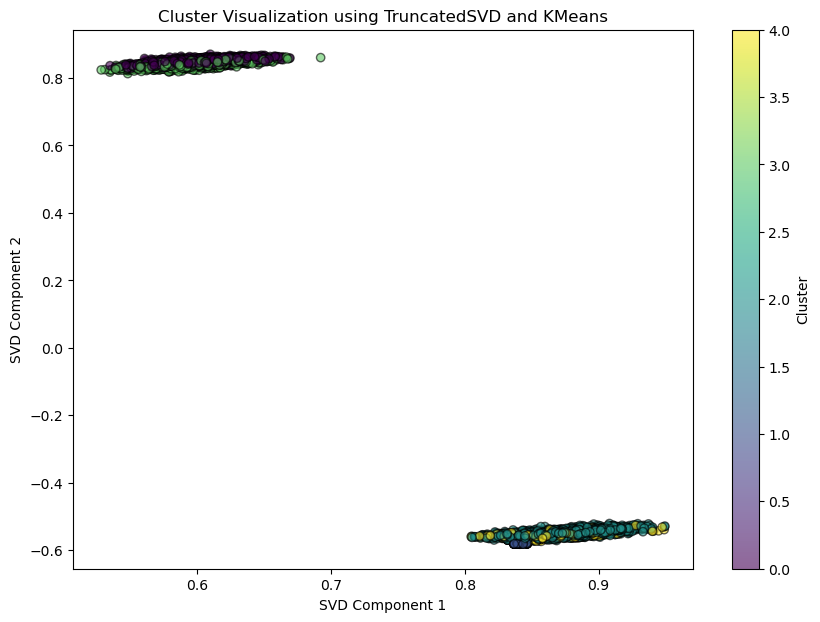

In [10]:
# Visualize clusters using the first two SVD components
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title("Cluster Visualization using TruncatedSVD and KMeans")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.colorbar(label="Cluster")
plt.show()
